# Chapter #3: Statistical Experiments and Significance Testing

Based on Practical Statistics for Data Scientists

Existe uma pipeline para a clássica inferência estatística:
1. Levantamento de Hipóteses
2. Design do experimento
3. Coletagem de dados
4. Inferências ou conclusões

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random

### A/B TEST

É um experimento com dois grupos que recebem tratamentos diferentes. No ramo empresarial é muito utilizado em marketing ou web design, exemplos:
- Teste de dois preços para determinar qual gera mais lucro.
- Teste de dois títulos para uma página web a fim de determinar qual produz mais clicks.
- Teste de dois ads para determinar qual gera mais conversão.

Os indivíduos que participarão do teste A/B são atribuídos ao grupo A ou B aleatoriamente.
Qualquer diferença entre os grupos é motivada por uma das duas coisas:
- Pura chance.
- Efeito distinto de cada tratamento.

Deve-se estabelecer também a métrica de teste que usaremos para comparar os dois grupos. 

Podemos utilizar uma variável binária:

In [3]:
pd.DataFrame({
    "Conversion": [True, False],
    "Ad 1": [200, 23539],
    "Ad 2": [182, 22406]
})

,Conversion,Ad 1,Ad 2
0,True,200,182
1,False,23539,22406


Ou variáveis contínuas:

In [4]:
pd.DataFrame({
    "": ["Média de venda por página"],
    "Preço A": [3.87],
    "Preço B": [4.11]
})

,,Preço A,Preço B
0,Média de venda por página,3.87,4.11


### HYPOTHESIS TESTS (SIGNIFICANCE TESTS)

Propósito de ajudar voce a aprender se a chance aleatória foi responsável pelo efeito observado. Nós tendemos a subestimar a manifestação dos black swans

#### KEY TERMS FOR HYPOTHESIS TESTS
- **Null Hypothesis**: A hipótese em que a chance é a culpada
- **Alternative Hypothesis**: Contra-ponto da hipótese nula

#### The Null Hypothesis $H_0$
É a construção lógica que incorpora a noção de que nada especial aconteceu, e qualquer efeito observado é devido à chance.
- Envolve a premissa de que os tratamentos são equivalentes e qualquer diferença é devido à chance.
- Em relação a fórmulas matemáticas, normalmente está associada aos sinais de $=$, $\ge$, $\le$

#### The Alternative Hypothesis $H_1$
- A natureza da hipótese nula determina a hipótese alternativa, pois deve ser o contra-ponto da hipótese nula.
- Em relação a fórmulas matemáticas, normalmente está associada aos sinais de $\ne$, $\gt$, $\lt$

### RESAMPLING

- Usado para analisar a variabilidade aleatória em estatística
- Usado para melhorar a acurácia de algum modelo de ML

Existem dois tipos principais de procedimentos de reamostragem: bootstrap e testes de permutação. O bootstrap nos ajuda com intervalos de confiança e os testes de permutação nos ajudam com testes de hipóteses.

#### Permutation Test
Permutar significa mudar a ordem de um conjunto de valores. No teste de hipótese, o primeiro passo é a combinação dos resultados dos grupos A e B. Essa é a incorporação da hipótese nula que diz que qualquer diferença é devido à chance. 
1. Combine os resultados dos diferentes grupos em um único data set.
2. Embaralhe os dados combinados e retire aleatoriamente (sem substituição) uma amostra do mesmo tamanho do grupo A.
3. Os dados restantes pertencerão ao grupo B*
4. Calcule a estatística escolhida e anote.
5. Os passos anteriores constituem uma única iteração da permutação, então repita os passos anteriores R vezes para produzir a distribuição da permutação da estatística escolhida.

Agora volte à diferença observada antes da permutação e compare com a distribuição criada acima. Se a diferença observada estiver no meio da distribuição, falhamos em rejeitar a hipótese nula, portanto a diferença não é significativa estatisticamente.

**EXEMPLO 1**: Uma empresa vendendo serviços de alto-valor quer testar qual design da página faz um trabalho melhor em termos de vendas.

**Observações**:
1. Serviço de alto-valor, portanto, poucos "eventos de sucesso"
2. Google Analytics não mede o tempo de sessão da última sessão que alguém visita. Ao invés de deletar esses dados, Google .Analytics grava como um 0.

$\large{H_0: \mu_{pageA} - \mu_{pageB} \ge 0}$ 


$\large{H_1: \mu_{pageA} - \mu_{pageB} \lt 0}$ 

In [5]:
np.random.seed(10)

hvs = pd.concat([
    pd.DataFrame({"Page": ["A"]*21, "Time": stats.norm.rvs(3.5, 0.8, size=21)}),
    pd.DataFrame({"Page": ["B"]*15, "Time": stats.norm.rvs(3.5, 1, size=15) + .1})
]).reset_index(drop=True)

hvs.sample(5)

,Page,Time
32,B,3.732708
27,B,4.997996
3,A,3.493293
33,B,3.123858
19,A,2.636156


In [6]:
mean_A = hvs.query("Page == 'A'").Time.mean()
mean_B = hvs.query("Page == 'B'").Time.mean()

diff_obs = mean_A - mean_B
print("Diferença observada é de", np.round(diff_obs, 4))

Diferença observada é de -0.4773


In [7]:
def permutation_function(df, nA, nB, col):
    """
    Essa função executa um único passo do processo de reamostragem por permutação.
    """
    n = nA + nB
    idx_A = np.random.choice(np.arange(n), nA, replace=False)
    idx_B = np.setdiff1d(np.arange(n), idx_A)
    return df.loc[idx_A, col].mean() - df.loc[idx_B, col].mean()

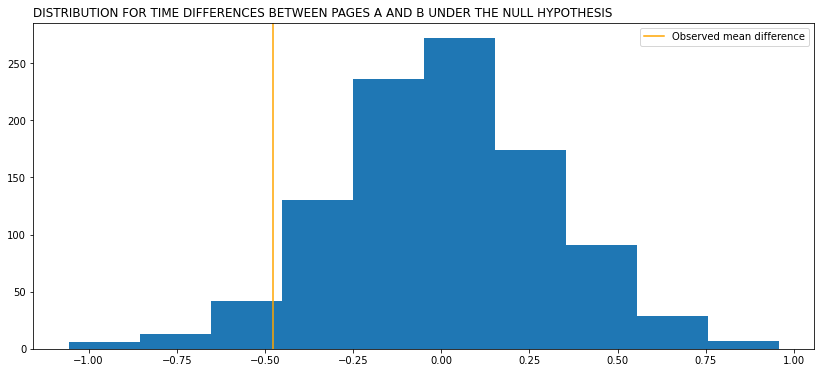

In [7]:
nA = hvs.Page.value_counts()["A"]
nB = hvs.Page.value_counts()["B"]

perm_diff = [permutation_function(hvs, nA, nB, "Time") for _ in range(1000)]

plt.figure(figsize=(14, 6))
plt.title("Distribution for time differences between pages A and B under the Null Hypothesis".upper(), loc="left")
plt.hist(perm_diff)
plt.axvline(diff_obs, color="orange", label="Observed mean difference")
plt.legend();

O grafico acima mostra que a diferença observada está dentro do que é esperado no intervalo de variação apenas por chance. Portanto, a diferença observada não é estatisticamente significativa.

#### p-Value
Representa a probabilidade de obter resultados tão, ou ainda mais, extremos que o resultado observado considerando que a hipótese nula é a correta.
No caso acima, o p-Value é a probabilidade dos valores à esquerda da linha laranja ocorrerem. Podemos calculá-lo da seguinte forma:

In [8]:
p_value = np.mean(np.array(perm_diff) < diff_obs)

print("p-Value:", p_value)
print("Considerando que não há diferença estatística significativa entre os tempos médios de cada página, podemos esperar que haja diferenças tão extremas como a observada simplesmente por chance em {}% do tempo".format(100*p_value))

p-Value: 0.054
Considerando que não há diferença estatística significativa entre os tempos médios de cada página, podemos esperar que haja diferenças tão extremas como a observada simplesmente por chance em 5.4% do tempo


#### Alpha
Nesse caso, mesmo havendo a chance de se observar diferenças tão extremas ou ainda mais extremas que a observada, ela é baixa. Portanto, criaram o **Alpha** que é basicamente um limite de aceitação de p-Value. Você passa o poder rejeitar a hipótese nula caso a probabilidade de se encontrar valores extremos superiores ao valor observado seja inferior ao valor definido por Alpha.

A escolha do Alpha é arbitrária. Mas seus valores tipicamente são 5% ou 1%, ou seja, 0.05 ou 0.01.

In [9]:
alpha = 0.05

if p_value <= alpha:
    print("p-Value <= Alpha\n")
    print("Rejeitamos a hipótese nula.\n")
    print("A diferença entre as médias de tempo em cada página são estatísticamente significativas")
else:
    print("p-Value > Alpha\n")
    print("Aceitamos a hipótese nula.\n")
    print("A diferença entre as médias de tempo em cada página não são estatísticamente significativas, ou seja, se houver diferença, é devido à chance.")

p-Value > Alpha

Aceitamos a hipótese nula.

A diferença entre as médias de tempo em cada página não são estatísticamente significativas, ou seja, se houver diferença, é devido à chance.


#### Type 1 and Type 2 Errors

||Aceitar $H_0$|Rejeitar $H_0$|
|---|---|---|
|$H_0$ Verdadeira|Alright|Erro **Tipo I**|
|$H_0$ Falsa|Erro **Tipo II**|Alright|

$\alpha$ = P(Erro tipo I)

$\beta$ = P(Erro tipo II)

O teste de hipótese serva para te proteger de ser enganado pela aleatoriedade.

O apha é exatamente a probabilidade de acontecer o erro do tipo I. Portanto, quanto menor o alpha, menor a chance de cometer o erro do tipo 1.

**EXEMPLO 2**: Desejam verificar qual preço A ou B converte mais. 

**Observações**:
1.  Cerca de 45,000 pessoas participaram do teste A/B (sem saber)
2. Apesar de termos um alto volume de dados e ser tentador considerar o caso como BIG DATA (que não costuma precisar de testes de significância estatística), a taxa de conversão é muito baixa e acaba que precisamos verificar se a diferença de cerca de 4% é devida à chance ou não.

$\large{H_0: \mu_{priceA} - \mu_{priceB} \le 0}$ 


$\large{H_1: \mu_{priceA} - \mu_{priceB} \gt 0}$ 

In [8]:
nA = 23739
nB = 22588
cA = 200
cB = 182

df = pd.DataFrame({
    "price": ["A"] * nA + ["B"] * nB,
    "conversion": [1] * cA + [0] * (nA - cA) + [1] * cB + [0] * (nB - cB)
})

cont_table = pd.DataFrame(df.groupby("price").conversion.value_counts()).rename(columns={"conversion": "count"}).reset_index().sort_values(by=["price", "conversion"], ascending=[True, False])
cont_table

,price,conversion,count
1,A,1,200
0,A,0,23539
3,B,1,182
2,B,0,22406


In [9]:
props = df.groupby("price").conversion.mean()

prop_a = props["A"]
prop_b = props["B"]

real_diff = prop_a - prop_b
real_diff

0.0003675791182059275

In [10]:
def permutation_function(df, nA, nB, col):
    n = nA + nB
    idx_A = np.random.choice(np.arange(n), nA, replace=False)
    idx_B = np.setdiff1d(np.arange(n), idx_A)
    
    return df.loc[idx_A, col].mean() - df.loc[idx_B, col].mean()

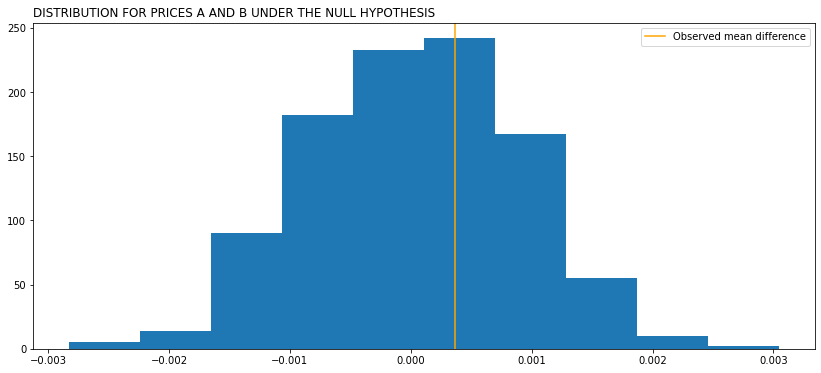

In [11]:
perm_diffs = [permutation_function(df, nA, nB, col="conversion") for _ in range(1_000)]

plt.figure(figsize=(14, 6))
plt.title("Distribution for prices A and B under the Null Hypothesis".upper(), loc="left")
plt.hist(perm_diffs)
plt.axvline(real_diff, color="orange", label="Observed mean difference")
plt.legend();

In [13]:
p_value = np.mean(np.array(perm_diffs) > np.array(real_diff)).mean()
print("p-Value:", p_value)

p-Value: 0.315


### t-Tests

- Antigamente, era mais complicado fazer permutações, então os estatísticos usavam t-Tests

In [14]:
stats.ttest_ind(hvs.query("Page == 'A'").Time, hvs.query("Page == 'B'").Time)

Ttest_indResult(statistic=-1.5860538358675174, pvalue=0.12198514440835194)

### MULTIPLE TESTING

Estamos testando 4 novas fórmulas para psoríase e queremos verificar se seus resultados são diferentes um do outro. Temos um teste A/B/C/D, podemos perguntar:
- A é diferente de B?
- A é diferente de C?
- A é diferente de D?
- B é diferente de C?
- B é diferente de D?
- C é diferente de D?


Isso leva ao fenômeno de inflação do Alpha.

**Alpha Inflation**: A probabilidade de cair em um erro do tipo I aumenta a medida que conduz mais testes.

Existem procedimentos estatísticos ajustados para comparações múltiplas.

### ANOVA

Quando estamos comparando resultados numéricos de múltiplos grupos (A/B/C/D), o procedimento estatístico para testar a significância estatística entre as diferenças desses grupos é chamado ANOVA (analysis of variance).

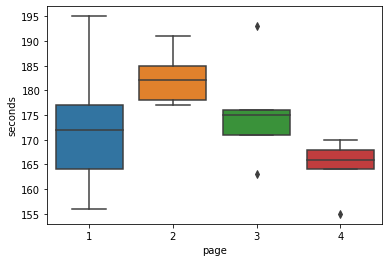

page
1    172.8
2    182.6
3    175.6
4    164.6
Name: seconds, dtype: float64

In [15]:
test_abcd = pd.DataFrame({
    "page": [1] * 5 + [2] * 5 + [3] * 5 + [4] * 5,
    "seconds": [164, 172, 177, 156, 195, 178, 191, 182, 185, 177, 175, 193, 171, 163, 176, 155, 166, 164, 170, 168]
})

test_abcd["page"] = test_abcd["page"].astype("category")

sns.boxplot(x="page", y="seconds", data=test_abcd)
plt.show();

test_abcd.groupby("page").seconds.mean()

Poderíamos comparar:
- Page 1 com page 2
- Page 1 com page 3
- Page 1 com page 4
- Page 2 com page 3
- Page 2 com page 4
- Page 3 com page 4

Porém, teríamos inflação do alpha e poderíamos ser enganos apenas pela chance aleatória. Então, ao invés de fazer cada uma das comparações entre pares de página individuais, fazemos uma única pergunta: 
**Poderia essas páginas ter a mesma retenção e suas diferenças ser apenas devidas à chance?**

Para testar isso, usamos o ANOVA:
1. Combine os dados de todos os grupos como se fossem um.
2. Embaralhe os dados e sorteie 4 amostragens com 5 valores cada.
3. Anote a média de cada um dos 4 grupos.
4. Anote a variância das médias dos 4 grupos.
5. Repita os passos 2-4 X vezes.

#### F-Statistic
Assim como o t-Test poderia ser usado ao invés do teste de permutação para comparar a média de dois grupo, existe um teste estatístico para ANOVA baseado na F-Statistic.

**Atentar para testes one-way, two-way**

#### KEY IDEAS
- ANOVA é um procedimento estatístico para analisar resultados de experimentos de múltiplos grupos

### CHI-SQUARE TEST
Imagine que você quer testar 3 manchetes diferentes para a sua notícia e voce testa cada uma delas em 1,000 visitantes aleatórios.

**Observado**

||M. 1|M. 2|M. 3|
|---|---|---|---|
|Click|14|8|12|
|No-click|986|992|988|

**Esperado**

||M. 1|M. 2|M. 3|
|---|---|---|---|
|Click|11.33|11.33|11.33|
|No-click|988.67|988.67|988.67|

#### Fisher's Exact Test
Usado quando você tem contages muito baixas (<= 5)

### MULTI-ARM BANDIT ALGORITHM

Pensando em uma máquina caça-níqueis especial que tem 3 braços (A/B/C).

**Observado**

|Arm|Wins|Out of|
|---|---|---|
|A|10|50|
|B|2|50|
|C|4|50|

- Epsilon

In [16]:
def define_design(n, epsilon):
    if n > epsilon:
        return "b"
    else:
        return np.random.choice(["a", "c"])
    
atribuicoes = pd.Series([define_design(np.random.random(), epsilon=.3) for _ in range(10_000)])

In [17]:
atribuicoes.value_counts()

b    7033
a    1491
c    1476
dtype: int64